# OpMet Challenge - Basic ML pipeline in Scikit Learn

This notebooks puts together a basic pipeline using scikit-learn

In [1]:
import pathlib
import datetime
import math
import functools
import numpy
import os

In [2]:
import pandas

In [3]:
import iris

In [4]:
import matplotlib

In [5]:
%matplotlib inline

In [6]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.neural_network
import sklearn.metrics

In [7]:
try:
    root_data_dir = os.environ['OPMET_DATA_ROOT']
except KeyError:
    root_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
root_data_dir    

'/Users/stephen.haddad/data/ml_challenges/'

## Exploring Falklands Rotor Data

In [8]:
falklands_dir = 'Rotors'
falklands_data_path = pathlib.Path(root_data_dir, falklands_dir)

In [9]:
falklands_new_training_data_path = pathlib.Path(falklands_data_path, 'new_training.csv')

In [10]:
falklands_training_df = pandas.read_csv(falklands_new_training_data_path, header=0).loc[1:,:]
falklands_training_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [11]:
falklands_training_df = falklands_training_df.drop_duplicates(subset='DTG')

In [12]:
falklands_training_df.shape

(17507, 95)

### Specify and create input features

In [13]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'

In [14]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

In [15]:
falklands_training_df[obs_names]

,air_temp_obs,dewpoint_obs,wind_speed_obs,wind_direction_obs
1,283.9,280.7,4.1,110.0
2,280.7,279.7,7.7,90.0
3,279.8,278.1,7.7,100.0
4,279.9,277.0,7.2,120.0
5,279.9,277.4,8.7,120.0
...,...,...,...,...
20101,276.7,275.5,3.6,270.0
20102,277.9,276.9,3.1,270.0
20103,283.5,277.1,3.6,220.0
20104,286.1,276.9,3.6,250.0


In [16]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [17]:
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/4212466182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/4212466182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')


In [18]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/495145632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/495145632.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')


In [19]:
falklands_training_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,4.714890e-16
3,279.8,278.1,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,-4.350000e+00
...,...,...,...,...
20101,276.7,275.5,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-1.231273e+00


In [20]:
falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
falklands_training_df.loc[falklands_training_df[falklands_training_df['Rotors 1 is true'].isna()].index, target_feature_name] = 0.0
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/2394283915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/2394283915.py:3: 

In [21]:
falklands_training_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors_present, dtype: int64

In [22]:
falklands_training_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'v_wind_19', 'u_wind_20', 'v_wind_20', 'u_wind_21', 'v_wind_21',
       'u_wind_22', 'v_wind_22', 'u_wind_obs', 'v_wind_obs', 'rotors_present'],
      dtype='object', length=142)

### SPlit into traing/validate/test sets

In [23]:
test_fraction = 0.1
validation_fraction = 0.1

In [24]:
num_no_rotors = sum(falklands_training_df[target_feature_name] == False)
num_with_rotors = sum(falklands_training_df[target_feature_name] == True)

In [25]:
data_no_rotors = falklands_training_df[falklands_training_df[target_feature_name] == False]
data_with_rotors = falklands_training_df[falklands_training_df[target_feature_name] == True]

In [26]:
data_test = pandas.concat([data_no_rotors.sample(int(test_fraction * num_no_rotors)), data_with_rotors.sample(int(test_fraction * num_with_rotors))])
data_test[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [27]:
falklands_training_df['test_set'] = False
falklands_training_df.loc[data_test.index,'test_set'] = True

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/1871749377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df['test_set'] = False


In [28]:
data_working = falklands_training_df[falklands_training_df['test_set'] == False]
data_working_no_rotors = data_working[data_working[target_feature_name] == False]
data_working_with_rotors = data_working[data_working[target_feature_name] == True]

In [29]:
data_validation = pandas.concat(
    [data_working_no_rotors.sample(int(validation_fraction * num_no_rotors)), 
     data_working_with_rotors.sample(int(validation_fraction * num_with_rotors))])
falklands_training_df['validation_set'] = False
falklands_training_df.loc[data_validation.index,'validation_set'] = True

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14516/2574544301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df['validation_set'] = False


In [30]:
data_validation[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [31]:
data_train = falklands_training_df[(~falklands_training_df['test_set']) & (~falklands_training_df['validation_set'])]

In [32]:
data_train[target_feature_name].value_counts()

False    13648
True       361
Name: rotors_present, dtype: int64

# Preprocess data into input for ML algorithm

In [33]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [34]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict[if1] = scaler1

In [35]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(data_train[[target_feature_name]])

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

Apply transformation to each input column

In [36]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [37]:
X_train = preproc_input(data_train, preproc_dict)
y_train = preproc_target(data_train, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


create target feature from rotors

In [38]:
y_train.shape, X_train.shape

((14009,), (14009, 88))

In [39]:
X_val = preproc_input(data_validation, preproc_dict)
y_val = preproc_target(data_validation, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [40]:
X_test = preproc_input(data_test, preproc_dict)
y_test = preproc_target(data_test, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [41]:
train_val_test_tuples = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),    
]

### train some classifiers

In [42]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}



In [43]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train, y_train)
    classifiers_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 18min 51s, sys: 9.7 s, total: 19min 1s
Wall time: 4min 50s


In [44]:
for clf_name, clf1 in classifiers_dict.items():
    for X1, y1 in train_val_test_tuples:
        print(sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1))

(array([0.88547773, 0.99445983]), array([0.99983453, 0.1867846 ]), array([0.93918788, 0.31449847]), array([12087,  1922]))
(array([0.87565982, 0.72727273]), array([0.99202658, 0.13114754]), array([0.93021807, 0.22222222]), array([1505,  244]))
(array([0.87917889, 0.79545455]), array([0.99403183, 0.14522822]), array([0.93308434, 0.24561404]), array([1508,  241]))
(array([0.89375733, 0.99722992]), array([0.99991803, 0.19889503]), array([0.94386196, 0.3316444 ]), array([12199,  1810]))
(array([0.88914956, 0.72727273]), array([0.9921466 , 0.14479638]), array([0.93782864, 0.24150943]), array([1528,  221]))
(array([0.89325513, 0.75      ]), array([0.9928292 , 0.15348837]), array([0.94041371, 0.25482625]), array([1534,  215]))
(array([0.99963365, 0.95290859]), array([0.99875549, 0.98567335]), array([0.99919438, 0.96901408]), array([13660,   349]))
(array([0.98357771, 0.15909091]), array([0.97841307, 0.2       ]), array([0.98098859, 0.17721519]), array([1714,   35]))
(array([0.9888563 , 0.1818

In [45]:
for clf_name, clf1 in classifiers_dict.items():
    for X1, y1 in train_val_test_tuples:
        print(sklearn.metrics.balanced_accuracy_score(clf1.predict(X1), y1))


0.5933095661724781
0.5615870595283481
0.5696300230031808
0.5994065268460099
0.5684714884745682
0.5731587883933174
0.9922144214593462
0.5892065344224038
0.6376951864756742
0.9217312730157251
0.6025390156062425
0.6207800721075057


In [46]:
for clf_name, clf1 in classifiers_dict.items():
    for X1, y1 in train_val_test_tuples:
        print(sklearn.metrics.confusion_matrix(clf1.predict(X1), y1))

[[12085     2]
 [ 1563   359]]
[[1493   12]
 [ 212   32]]
[[1499    9]
 [ 206   35]]
[[12198     1]
 [ 1450   360]]
[[1516   12]
 [ 189   32]]
[[1523   11]
 [ 182   33]]
[[13643    17]
 [    5   344]]
[[1677   37]
 [  28    7]]
[[1686   36]
 [  19    8]]
[[13583     9]
 [   65   352]]
[[1667   33]
 [  38   11]]
[[1665   30]
 [  40   14]]


In [47]:
sklearn.metrics.confusion_matrix(classifiers_dict['decision_tree'].predict(X_val), y_val)

array([[1493,   12],
       [ 212,   32]])

In [48]:
sklearn.metrics.confusion_matrix(classifiers_dict['random_forest'].predict(X_val), y_val)

array([[1516,   12],
       [ 189,   32]])

### Resample the data 

Our yes/no classes for classification are very unbalanced, so we can try doing a naive resampling so we have equal representation fo the two classes in our sample set.

In [49]:
data_train_resampled = pandas.concat([
    data_train[data_train[target_feature_name] == True].sample(n=int(1e4), replace=True), 
    data_train[data_train[target_feature_name] == False].sample(n=int(1e4), replace=False),],
    ignore_index=True)

In [50]:
X_train_resampled = preproc_input(data_train_resampled, preproc_dict)
y_train_resampled = preproc_target(data_train_resampled, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [51]:
train_val_test_res_tuples = [
    (X_train_resampled, y_train_resampled),
    (X_val, y_val),
    (X_test, y_test),    
]

In [52]:
%%time
classifiers_res_dict = {}                    
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train_resampled, y_train_resampled)
    classifiers_res_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 18min 48s, sys: 17.2 s, total: 19min 5s
Wall time: 4min 52s


In [53]:
for clf_name, clf1 in classifiers_res_dict.items():
    for X1, y1 in train_val_test_res_tuples:
        print(sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1))


(array([0.8824, 0.9828]), array([0.98088039, 0.89312977]), array([0.92903769, 0.93582175]), array([ 8996, 11004]))
(array([0.86803519, 0.75      ]), array([0.9926224 , 0.12790698]), array([0.9261577 , 0.21854305]), array([1491,  258]))
(array([0.86744868, 0.86363636]), array([0.9959596 , 0.14393939]), array([0.92727273, 0.24675325]), array([1485,  264]))
(array([0.8919, 1.    ]), array([1.        , 0.90244563]), array([0.94286167, 0.9487216 ]), array([ 8919, 11081]))
(array([0.88152493, 0.75      ]), array([0.99273448, 0.14042553]), array([0.93383038, 0.23655914]), array([1514,  235]))
(array([0.88680352, 0.79545455]), array([0.99408284, 0.15350877]), array([0.93738376, 0.25735294]), array([1521,  228]))
(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([10000, 10000]))
(array([0.98416422, 0.22727273]), array([0.98014019, 0.27027027]), array([0.98214808, 0.24691358]), array([1712,   37]))
(array([0.98944282, 0.22727273]), array([0.98024404, 0.35714286]), array([0.98482195, 0.27

In [54]:
for clf_name, clf1 in classifiers_res_dict.items():
    for X1, y1 in train_val_test_res_tuples:
        print(sklearn.metrics.balanced_accuracy_score(clf1.predict(X1), y1))    

0.937005081138691
0.5602646889086457
0.569949494949495
0.951222813825467
0.5665800050591642
0.5737958060832554
1.0
0.6252052285930791
0.6686934506516146
1.0
0.5803519061583577
0.6475162527087848


In [55]:
for clf_name, clf1 in classifiers_res_dict.items():
    for X1, y1 in train_val_test_res_tuples:
        print(sklearn.metrics.confusion_matrix(clf1.predict(X1), y1))

[[8824  172]
 [1176 9828]]
[[1480   11]
 [ 225   33]]
[[1479    6]
 [ 226   38]]
[[ 8919     0]
 [ 1081 10000]]
[[1503   11]
 [ 202   33]]
[[1512    9]
 [ 193   35]]
[[10000     0]
 [    0 10000]]
[[1678   34]
 [  27   10]]
[[1687   34]
 [  18   10]]
[[10000     0]
 [    0 10000]]
[[1669   36]
 [  36    8]]
[[1681   33]
 [  24   11]]


### Including observations

Other challenge participants have used observations as input. This makes it less of a forecast and more of a nowcast, but would be good for comparing.

In [56]:
input_feature_names_obs = obs_feature_names + temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [57]:
preproc_dict_obs = {}
for if1 in input_feature_names_obs:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict_obs[if1] = scaler1

In [58]:
X_train_obs = preproc_input(data_train, preproc_dict_obs)
y_train_obs = preproc_target(data_train, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [59]:
X_val_obs = preproc_input(data_validation, preproc_dict_obs)
y_val_obs = preproc_target(data_validation, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [60]:
X_test_obs = preproc_input(data_test, preproc_dict_obs)
y_test_obs = preproc_target(data_test, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [61]:
train_val_test_obs_tuples = [
    (X_train_obs, y_train_obs),
    (X_val_obs, y_val_obs),
    (X_test_obs, y_test_obs),    
]

In [62]:
%%time
classifiers_obs_dict = {}                    
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train_obs, y_train_obs)
    classifiers_obs_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 20min 8s, sys: 7.5 s, total: 20min 16s
Wall time: 5min 9s


In [63]:
for clf_name, clf1 in classifiers_obs_dict.items():
    for X1, y1 in train_val_test_obs_tuples:
        print(sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1))

(array([0.8885551 , 0.99168975]), array([0.99975268, 0.19052688]), array([0.94087982, 0.31964286]), array([12130,  1879]))
(array([0.87917889, 0.72727273]), array([0.99205824, 0.13445378]), array([0.93221393, 0.22695035]), array([1511,  238]))
(array([0.88269795, 0.79545455]), array([0.99405548, 0.14893617]), array([0.935073  , 0.25089606]), array([1514,  235]))
(array([0.89419695, 0.99722992]), array([0.99991807, 0.19955654]), array([0.94410707, 0.33256351]), array([12205,  1804]))
(array([0.88856305, 0.72727273]), array([0.99214145, 0.14414414]), array([0.9375   , 0.2406015]), array([1527,  222]))
(array([0.89560117, 0.75      ]), array([0.99284785, 0.1563981 ]), array([0.94172063, 0.25882353]), array([1538,  211]))
(array([1.        , 0.88919668]), array([0.99707773, 1.        ]), array([0.99853673, 0.94134897]), array([13688,   321]))
(array([0.99178886, 0.13636364]), array([0.97802198, 0.3       ]), array([0.98485731, 0.1875    ]), array([1729,   20]))
(array([0.99296188, 0.136363

In [64]:
for clf_name, clf1 in classifiers_obs_dict.items():
    for X1, y1 in train_val_test_obs_tuples:
        print(sklearn.metrics.balanced_accuracy_score(clf1.predict(X1), y1))    

0.5951397776526867
0.5632560105445222
0.5714958261896061
0.5997373036930995
0.5681427989875927
0.5746229793108548
0.9985388661601402
0.639010989010989
0.6556903523974581
0.99992673992674
0.6139855072463768
0.6318617724867726


In [65]:
for clf_name, clf1 in classifiers_obs_dict.items():
    for X1, y1 in train_val_test_obs_tuples:
        print(sklearn.metrics.confusion_matrix(clf1.predict(X1), y1))

[[12127     3]
 [ 1521   358]]
[[1499   12]
 [ 206   32]]
[[1505    9]
 [ 200   35]]
[[12204     1]
 [ 1444   360]]
[[1515   12]
 [ 190   32]]
[[1527   11]
 [ 178   33]]
[[13648    40]
 [    0   321]]
[[1691   38]
 [  14    6]]
[[1693   38]
 [  12    6]]
[[13648     2]
 [    0   359]]
[[1687   38]
 [  18    6]]
[[1690   38]
 [  15    6]]


## Plot SEDI for different classifiers and thresholds

In [75]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [102]:
y_train_pred_raw = classifiers_dict['random_forest'].predict_proba(X_train)[:,1]
y_val_pred_raw = classifiers_dict['random_forest'].predict_proba(X_val)[:,1]
y_test_pred_raw = classifiers_dict['random_forest'].predict_proba(X_test)[:,1]

In [108]:
import warnings
warnings.filterwarnings('ignore')

In [109]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in thresholds_list:
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train, y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

    

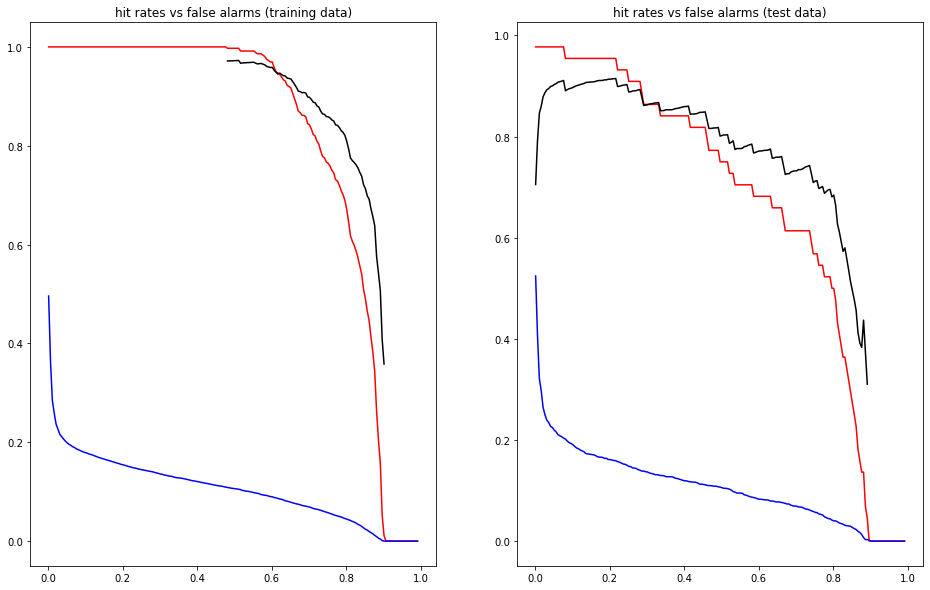

In [110]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

## Further work
Changing decision threshold 
* make use of predict probability functionality in scikit learn
* plot  hit rate, false alarm rate and SEDI for different thresholds in different classifiers
* compare forn with obs, without obs and resampling data

Improviong accuracy
* more sophisticated resampling (e.g. SMOTE)
* proper hyperpamater tuning to get best results with each classifier
* try other tree and NN implementations e.g. tensorflow, pytorch, xgboost
* try dimensionality reduction step

Result presentation/investigation
* some visualisation of results
* consolidate output into data frames
* look atfeature importance measures to see which features are most important

MLOps
* do hypyerparamter tuning using dask cluster
* execute training on spice (create SPICE dask cluster)
* save experiment details in experiment using MLflow
* replicate workflow
